# Information Retrieval

In [1]:
# Imports
## General
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from toolbox import *


## Data retrieval
import os

## Data exploration
import glob
from nltk.tokenize import wordpunct_tokenize
from wordcloud import WordCloud

## Pre-processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

## Pyserini
from pyserini.index import IndexReader
from pyserini.search.lucene import LuceneSearcher

## Models
import torch
import tensorflow as tf

import gensim.downloader as api
import simple_elmo
from simple_elmo import ElmoModel
from transformers import BertTokenizer, BertModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxneerken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data retrieval

First we download the msmarco passage and index our documents in Lucene.

In [2]:
# Download msmarco
if not os.path.exists('data/msmarco_passage'):
    # Download
    print('1/4 Start download')
    !curl https://msmarco.blob.core.windows.net/msmarcoranking/collection.tar.gz -o data/msmarco_passage/collection.tar.gz --create-dirs

    # Unzip
    print('2/4 Unzip')
    !tar xvfz data/msmarco_passage/collection.tar.gz -C data/msmarco_passage

    # Map .tsv to .json
    print('3/4 Map tsv to json')
    !git clone https://github.com/castorini/anserini.git
    !cd anserini && git checkout ad5ba1c76196436f8a0e28efdb69960d4873efe3
    !cd anserini && python ./src/main/python/msmarco/convert_collection_to_jsonl.py --collection_path ../data/msmarco_passage/collection.tsv --output_folder ../data/msmarco_passage/collection_jsonl

    # Clean up
    print('4/4 Clean up')
    !rm data/msmarco_passage/collection.tar.gz
    !rm data/msmarco_passage/*.tsv
    !rm -rf sample_data
    !rm -rf -v anserini

In [6]:
# Index documents with Lucene
if not os.path.exists('indexes/'):
    !python -m pyserini.index.lucene -collection JsonCollection -generator DefaultLuceneDocumentGenerator -threads 9 -input data/msmarco_passage/collection_jsonl -index indexes/lucene-index-msmarco-passage -storePositions -storeDocvectors -storeRaw

Then we fetch our queries and documents.

In [7]:
# Download queries and qrels
if not os.path.exists('data/queries/'):
    !curl https://msmarco.blob.core.windows.net/msmarcoranking/passv2_train_queries.tsv -o data/queries/queries.docdev.tsv --create-dirs
    !curl https://msmarco.blob.core.windows.net/msmarcoranking/passv2_train_qrels.tsv -o data/queries/qrels.docdev.tsv --create-dirs

In [167]:
# Fetch queries and qrels
queries = pd.read_csv('data/queries/queries.docdev.tsv', sep='\t', names=['query_id', 'query'])
qrels = pd.read_csv('data/queries/qrels.docdev.tsv', sep='\t', names=['query_id', 'iteration', 'document_id', 'relevancy'])

queries = queries.merge(qrels.drop_duplicates(), on=['query_id', 'query_id'], how='inner', indicator=True)[['query_id', 'query']]

In [4]:
# Collect documents
documents = pd.DataFrame(columns=['id', 'contents'])
docs_filenames = glob.glob('data/msmarco_passage/collection_jsonl/*.json')

for filename in docs_filenames:
    file_docs = pd.read_json(filename, lines=True)
    documents = pd.concat([documents, file_docs], ignore_index=True)

There are a lot of queries, and we do not want to run all of them. So we sample them.

In [169]:
queries = queries.sample(100, random_state=1)

# 2. Data exploration
We will start with some data exploration, to gain a better understanding of what we are dealing with and what pre-processing steps we should consider.

First we create an index reader and look at some of the dataset statistics.

In [6]:
index_reader = IndexReader('indexes/lucene-index-msmarco-passage')
lucene_stats = index_reader.stats()

print(f'Number of queries:   {len(queries)}')
print(f'Number of documents: {lucene_stats["documents"]}')

Number of queries:   100
Number of documents: 8841823


Now we will sample some documents to:
1. Look into the document length statistics and plot the number of words per document in a histogram
2. Plot the most common words in a wordcloud
3. Print some documents to look into

In [23]:
sample = documents.sample(10000, random_state=1)

In [24]:
# Document length statistics
queries_words = list(map(lambda x: wordpunct_tokenize(x), queries['query']))
docs_words = list(map(lambda x: wordpunct_tokenize(x), sample['contents']))

query_lengths = np.array(list(map(lambda x: len(x), queries_words)))
doc_lengths = np.array(list(map(lambda x: len(x), docs_words)))

print(f'Average query length: {query_lengths.mean()}')
print(f'Minimum query length: {query_lengths.min()}')
print(f'Maximum query length: {query_lengths.max()}')
print()
print(f'Average document length: {doc_lengths.mean()}')
print(f'Minimum document length: {doc_lengths.min()}')
print(f'Maximum document length: {doc_lengths.max()}')

Average query length: 5.89
Minimum query length: 2
Maximum query length: 14

Average document length: 68.6829
Minimum document length: 12
Maximum document length: 272


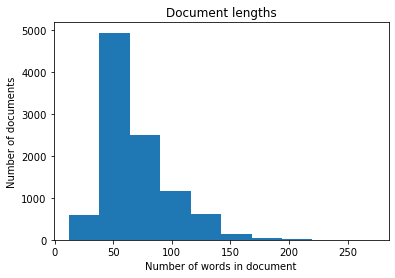

Figure 1. Histogram of the number of words per sampled document


In [10]:
# Histogram
plt.hist(doc_lengths)
plt.xlabel('Number of words in document')
plt.ylabel('Number of documents')
plt.title('Document lengths')
plt.show()
print('Figure 1. Histogram of the number of words per sampled document')

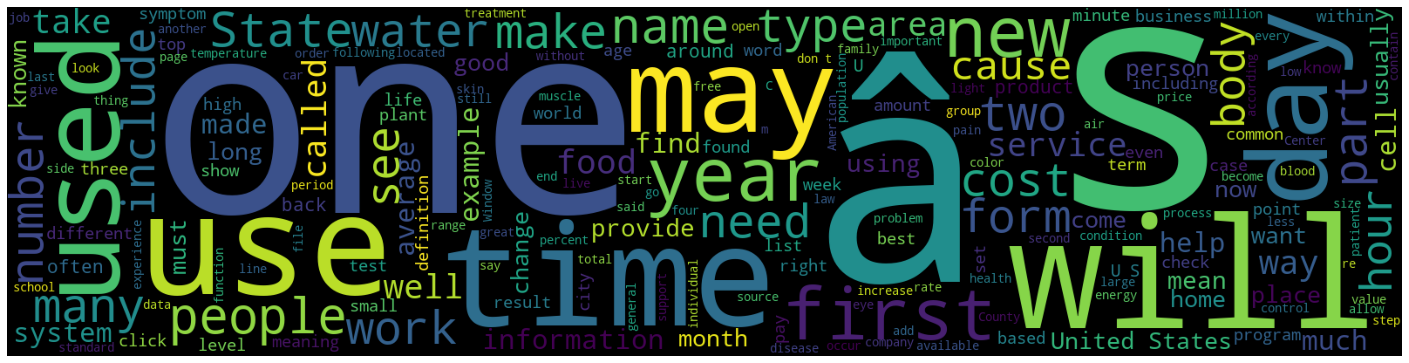

Figure 2. Wordcloud of most common words in documents sample


In [11]:
# Wordcloud
contents = ' '.join([word for word_list in docs_words for word in word_list])

wordcloud = WordCloud(width=1600,height=400).generate(contents)
plt.figure(figsize = (25,25))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
print('Figure 2. Wordcloud of most common words in documents sample')

In [12]:
# Print samples
n_samples = 5
for idx, document in enumerate(documents['contents'].iloc[:n_samples], 1):
    print(f'\033[1m- Document {idx}:\033[0m')
    print(document)
    print()

- Document 1:
As a rule of thumb, you generally know your Rottweiler has stopped growing once he has reached the weight and height standards of the breed. Male Rottweilers grow to be between 24 to 27 inches at the withers, according to American Kennel Club standard. Females, on the other paw, should reach a height between 22 to 25 inches. Proportionally, the length of your Rottweiler's body should be overall slightly longer than his height.

- Document 2:
Ready, steady, grow. As a proud Rottweiler puppy owner, you may wonder how long it takes for your butterball to grow into the handsome, powerful dog you have seen in many breed books. Get ready for some thumb-twiddling; Rottweilers are a slow-growing breed, and it takes some time for them to stop growing.

- Document 3:
Every dog is different as far as hip problems goes and it could live a year to a few years its really hard to say but i've seen rotties with hip problems live to be 14 or 16 so chances are its still awhile.

- Document

# 3. Data pre-processing

In [7]:
def preprocess_w2v(texts):
    stopword_set = set(stopwords.words('english'))
    stopword_set.add('.')
    stopword_set.add(',')
    stopword_set.add('!')
    stopword_set.add('?')
    processed_texts = []
    for text in texts:
        # Stopword removal
        words = wordpunct_tokenize(text)
        processed_texts.append(list([word for word in words if not word.lower() in stopword_set]))
    return processed_texts
    

# 4. Model implementation

## 4.0 BM25

Since we use our embedding models for document reranking, we first use BM25 to fetch top 100 documents per query to rerank.

In [85]:
# Spare retrieval using pyserini
n_results = 100
top_100 = []
searcher = LuceneSearcher("indexes/lucene-index-msmarco-passage")

for idx, (qid, query) in queries.iterrows():
    hits = searcher.search(q=query, k=n_results)
    hits = list(map(lambda hit: json.loads(hit.raw), hits))
    doc_ids = list(map(lambda hit: hit['id'], hits))
    docs = list(map(lambda hit: hit['contents'], hits))
    
    top_100.append({'qid': qid, 'query': query, 'doc_ids': doc_ids, 'docs': docs})

955695
722160
1072984
1183614
55576
120439
430393
1065432
249244
277645
903049
696567
626821
99443
715812
514685
993380
592123
593655
20102
189844
417034
922704
83593
280365
742749
685947
136811
339762
948066
847888
57266
1052093
1149228
30199
679512
884496
277654
916353
689513
948908
987223
220875
354989
862290
194960
848830
448534
673456
572920
537268
678177
621045
1056944
1183904
94401
184960
387928
228921
1035160
750058
956617
146086
813426
385209
660256
36161
161804
228430
1153410
1005844
669022
776127
1154132
305947
601391
406454
792229
1150432
694359
691059
709193
264992
825010
867359
407578
948246
477211
897423
499217
970845
134332
38362
37945
452291
1030997
572100
111025
800932
517958


## 4.1 Word2Vec

First we will load a word2vec model and define a function to turn texts into text embeddings.

In [9]:
# Load Google's pre-trained Word2Vec model.
w2v_model = api.load('word2vec-google-news-300')

In [76]:
# Convert texts to word2vec embeddings
def texts_to_w2v_embeddings(texts):
    text_embeddings = []
    for text in texts:
        # Generate word embeddings
        word_embeddings = []
        for word in text:
            try:
                word_embedding = w2v_model[word]
            except KeyError:
                continue
            word_embeddings.append(word_embedding)
        
        # Convert word embeddings to text embedding
        text_embedding = torch.mean(torch.Tensor(np.array(word_embeddings)), dim=0)
        text_embeddings.append(text_embedding)
    return torch.stack(text_embeddings)

Now we will turn the top 100 documents into embeddings and calculate cosine similarity scores with their corresponding queries.

In [77]:
cos = torch.nn.CosineSimilarity(dim=1)
results_w2v = []

for idx, results in enumerate(top_100):
    # Generate embeddings
    query_embedding = texts_to_w2v_embeddings(preprocess_w2v([results['query']]))
    doc_embeddings = texts_to_w2v_embeddings(preprocess_w2v(results['docs']))

    # Calculate scores
    cosine_similarities = cos(query_embedding, doc_embeddings).tolist()
    ranks = score_to_rank(cosine_similarities)

    # Gather results
    query_result = np.array([
        [results['qid']]*len(results['docs']), 
        results['doc_ids'], 
        ranks, 
        cosine_similarities, 
        ['word2vec']*len(results['docs'])]).T
    results_w2v.extend(query_result)

results_w2v = pd.DataFrame(results_w2v, columns=['query_id', 'document_id', 'rank', 'score', 'run'])

## 4.2 ElMo

First we will load an Elmo model and define a function to turn texts into text embeddings.

In [66]:
if not os.path.exists('models/elmo/'):
    !curl https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5 -o models/elmo/model.hdf5 --create-dirs
    !curl https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json -o models/elmo/options.json --create-dirs

In [68]:
# Initialise Elmo
elmo_model = ElmoModel()

graph = tf.Graph()
with graph.as_default() as elmo_graph:
    elmo_model = ElmoModel()
    elmo_model.load('models/elmo')

with elmo_graph.as_default() as current_graph:
    tf_session = tf.compat.v1.Session(graph=elmo_graph)
    with tf_session.as_default() as sess:
        elmo_model.elmo_sentence_input = simple_elmo.elmo.weight_layers("input", elmo_model.sentence_embeddings_op)
        sess.run(tf.compat.v1.global_variables_initializer())

2022-12-12 13:45:43,424 : INFO : Loading model from models/elmo...
2022-12-12 13:45:43,426 : INFO : No vocabulary file found in the model.
2022-12-12 13:45:43,426 : INFO : No vocabulary file provided; using special tokens only.
2022-12-12 13:45:43,426 : INFO : We will cache the vocabulary of 3 tokens.
/Users/maxneerken/miniconda3/envs/ir/lib/python3.10/site-packages/simple_elmo/model.py:529: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(
2022-12-12 13:45:44.078386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 13:45:44.078406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created Tenso

In [67]:
# Convert texts to Elmo embeddings
def texts_to_elmo_embeddings(texts):
    texts = list(texts)
    word_embeddings = elmo_model.get_elmo_vectors(texts, session=tf_session)
    
    # Perform mean aggregation
    word_embeddings = torch.Tensor(np.array(word_embeddings))
    text_embeddings = torch.mean(word_embeddings, dim=1) 
    return text_embeddings

Now we will turn the top 100 documents into embeddings and calculate cosine similarity scores with their corresponding queries.

In [39]:
cos = torch.nn.CosineSimilarity(dim=1)
results_elmo = []

for idx, results in enumerate(top_100):
    # Generate embeddings
    query_embedding = texts_to_elmo_embeddings([results['query']])
    doc_embeddings = texts_to_elmo_embeddings(results['docs'])

    # Calculate scores
    cosine_similarities = cos(query_embedding, doc_embeddings).tolist()
    ranks = score_to_rank(cosine_similarities)

    # Gather results
    query_result = np.array([
        [results['qid']]*len(results['docs']), 
        results['doc_ids'], 
        ranks, 
        cosine_similarities, 
        ['elmo']*len(results['docs'])]).T
    results_elmo.extend(query_result)

results_elmo = pd.DataFrame(results_elmo, columns=['query_id', 'document_id', 'rank', 'score', 'run'])

RuntimeError: stack expects a non-empty TensorList

## 4.3 BERT

Now we will import our Bert model and create a function that lets us easily turn texts into embeddings.

In [ ]:
# Initialise Bert
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [70]:
# Convert texts to Bert embeddings
def texts_to_bert_embeddings(texts):
    texts = list(texts)
    tokens = bert_tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    outputs = bert_model(**tokens)
    word_embeddings = outputs.last_hidden_state.detach()
    
    # Perform mean aggregation
    text_embeddings = torch.mean(word_embeddings, dim=1) 
    return text_embeddings

Now we will turn the top 100 documents into embeddings and calculate cosine similarity scores with their corresponding queries.

In [118]:
cos = torch.nn.CosineSimilarity(dim=1)
results_bert = []

for idx, results in enumerate(top_100):
    # Generate embeddings
    query_embedding = texts_to_bert_embeddings([results['query']])
    doc_embeddings = texts_to_bert_embeddings(results['hits'])

    # Calculate scores
    cosine_similarities = cos(query_embedding, doc_embeddings).tolist()
    ranks = score_to_rank(cosine_similarities)

    # Gather results
    query_result = np.array([
        [results['qid']]*len(results['docs']), 
        results['doc_ids'], 
        ranks, 
        cosine_similarities, 
        ['bert']*len(results['docs'])]).T
    results_bert.extend(query_result)

results_bert = pd.DataFrame(results_bert, columns=['query_id', 'document_id', 'rank', 'score', 'run'])

NameError: name 'texts_to_bert_embeddings' is not defined

# 5. Model evaluation

First we will create a dictionary so we can easily look up relevant documents.

In [170]:
class relevancy_lookup(object):
    def __init__(self):
        self.relevancies = {}
    
    def add(self, query, document, relevancy):
        if query not in self.relevancies.keys():
            self.relevancies[query] = {}
        self.relevancies[query][document] = relevancy
        
    def get(self, query, document):
        if query not in self.relevancies.keys():
            print('Query does not exist sukkel')
        if document not in self.relevancies[query].keys():
            return 0
        return self.relevancies[query][document]

In [171]:
relevancies = relevancy_lookup()
for idx, (qid, doc_id, relevancy) in qrels[['query_id', 'document_id', 'relevancy']].iterrows():
    relevancies.add(str(qid), str(doc_id), relevancy)

Now we will retrieve the document ranking relevancies of the different models.

In [172]:
def get_ranked_labels(rel_lookup, query, doc_rank_list): 
    result = np.zeros(len(doc_rank_list), dtype=int)
    
    for x in doc_rank_list:
        result[int(x[1])-1] = rel_lookup.get(query, x[0])
    return result

def process_files():
    qids = set(results_w2v['query_id'])

    doc_rank_lists = []
    for qid in qids:
        query_rows = results_w2v[results_w2v['query_id']==qid][['document_id', 'rank']]
        doc_rank_list = get_ranked_labels(relevancies, qid, query_rows.to_numpy())
        doc_rank_lists.append(doc_rank_list)
    
    # Check if there is one relevant document anywhere
    for x in doc_rank_lists:
        for y in x:
            if y == 1:
                print(y)

process_files()

In [21]:
for qid in queries['query_id']:
    labels = qrels[qrels['query_id']==qid]['document_id']
    # query_id, document_id = qrels[qrels['query_id']==695572]

In [168]:
for query_id in quei
query_id, document_id = qrels[qrels['query_id']==695572]


,query_id,iteration,document_id,relevancy
2,695572,0,msmarco_passage_20_461843390,1


Finally, we will calculate the f-scores that correspond to the different models.